In [2]:
# Install Packages

import numpy as np
from scipy import stats
import pylab as plt
import torch
import pytorch_lightning as pl
import swyft
import matplotlib.pyplot as plt
%pylab inline
import scipy
import time
plt.rc("text", usetex=True)
plt.rc("font", family="Serif")
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0)
np.random.seed(0)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
# Define simulator parameters
freq = np.arange(5.00,1024,1/4)
pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100

# Define Simulator
class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, Nbins=4076, bounds=None):
        super().__init__()
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.freq = np.linspace(5., 1024 + (1024-5)/Nbins , Nbins)
        self.sample_z = swyft.RectBoundSampler([stats.loguniform(1e-8,1e-7), #alpha
                                                stats.uniform(0,3)], #omega alpha
                                                bounds = bounds) #bounds changes range of the prior

    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.C_groundtruth, z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m) #Ground truth wih sigma noise
        sigma = graph.node('sigma',self.sigma)

100%|██████████| 10000/10000 [00:07<00:00, 1398.11it/s]


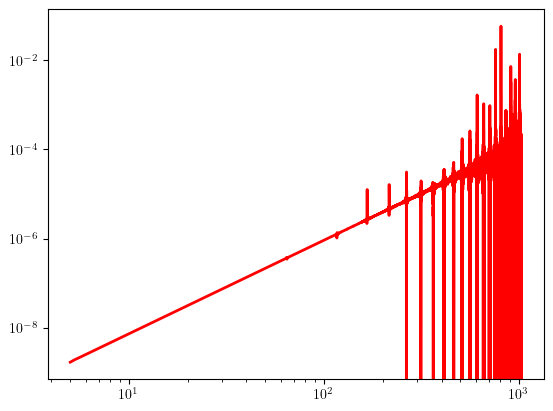

In [8]:
# Sample from Simulator

n_samples = 1000
fref = 25
CE_PSD = np.genfromtxt("data/cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("data/gamma_HL.txt")
T_obs = 365 * 24 * 3600

sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)

obs = sim.sample(conditions = {'z': np.array([5e-8, 2.1])})
samples = sim.sample(N = 10000)

plt.loglog(sim.freq, obs['x'], 'r', lw=2)

In [14]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        # Log-ratio estimator with 1 feature (x) and 2 parameters (alpha, omega)
        self.logratios = swyft.LogRatioEstimator_1dim(
            num_features=1,  # Number of features in x (simulated observation)
            num_params=2,    # Two parameters to infer: alpha and omega
            varnames=['omega', 'alpha'],  # Names of the parameters
            num_blocks=4     # Number of neural network blocks
        )

    def forward(self, A, B):
        return self.logratios(A['x'], B['m'])

In [15]:
trainer = swyft.SwyftTrainer(accelerator=DEVICE, precision=64)

# Step 4: Prepare the data module for training
dm = swyft.SwyftDataModule(samples, batch_size=128)

# Step 5: Instantiate and train the network
network = Network()
trainer.fit(network, dm)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_1dim | 69.1 K
-----------------------------------------------------
69.1 K    Trainable params
0         Non-trainable params
69.1 K    Tot

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [512, 2] but got: [512, 4077].

In [9]:
# Define swyft module

class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Linear(10, 2)
        self.logratios1 = swyft.LogRatioEstimator_1dim(num_features = 2, num_params = 2, varnames = 'z')
        self.logratios2 = swyft.LogRatioEstimator_Ndim(num_features = 2, marginals = ((0, 1),), varnames = 'z')

    def forward(self, A, B):
        embedding = self.embedding(A['x'])
        logratios1 = self.logratios1(embedding, B['z'])
        logratios2 = self.logratios2(embedding, B['z'])
        return logratios1, logratios2

In [10]:
# Train model
trainer = swyft.SwyftTrainer(accelerator = DEVICE)



GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [11]:
dm = swyft.SwyftDataModule(samples, batch_size = 64)


In [12]:
network = Network()
trainer.fit(network, dm)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | embedding  | Linear                 | 22    
1 | logratios1 | LogRatioEstimator_1dim | 34.9 K
2 | logratios2 | LogRatioEstimator_Ndim | 17.5 K
------------------------------------------------------
52.5 K    Trainable params
0         Non-trainable params
52.5 K    Total params
0.210     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x4076 and 10x2)